# Checking the Dependence of Local Cell Density vs. Nucleus Size

### Question:
Check whether increasing local cell density [pixels^2] impacts the size of the nucleus [pixels] as segmented by the U-Net. 

### Expectation: 
The nucleus size should be indirectly proportional to the local cell density; i.e as local cell density grows, the cell nucleus size decreases (should observe a diagonal from upper left corner to lower right corner)

### Observation:
Successful! 

### Methods: 

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

from Movie_Analysis_Pipeline.Single_Movie_Processing.Server_Movies_Paths import Get_MDCK_Movies_Paths


In [2]:
def Extract_Datasets(hdf5_file):
    
    with h5py.File(hdf5_file, 'r') as f:
        density = np.array(f["objects"]["obj_type_1"]["local_density"])
        nucleus = np.array(f["objects"]["obj_type_1"]["nucleus_size"])
        length = len(f["objects"]["obj_type_1"]["map"])
    
    return density, nucleus, length

### Representative 2D histogram plot for single movie (GV0800, pos0):

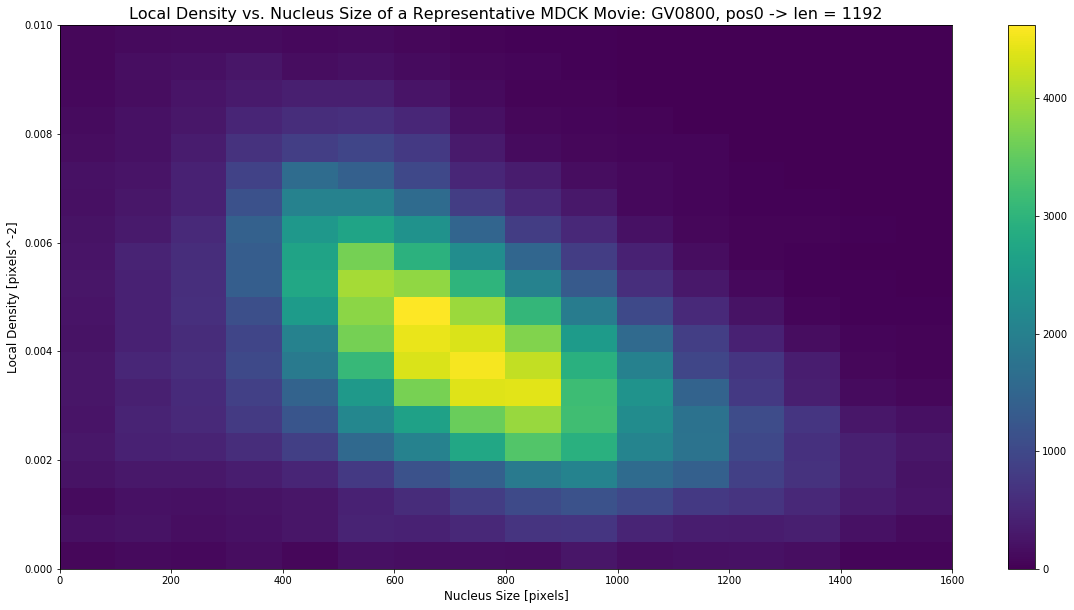

In [3]:
hdf5_file = "/Volumes/lowegrp/Data/Kristina/Cells_MDCK/GV0800/pos0/HDF/segmented.hdf5"
date, pos = hdf5_file.split("/")[-4], hdf5_file.split("/")[-3]
density, nucleus, length = Extract_Datasets(hdf5_file=hdf5_file)

# Plot 2D histogram:
_ = plt.figure(figsize=(20, 10))
plt.hist2d(x=nucleus, y=density, bins=[16, 20], range=[[0, 1600], [0, 0.01]])
plt.title("Local Density vs. Nucleus Size of a Representative MDCK Movie: {}, {} -> len = {}".format(date, pos, length), fontsize=16)
plt.xlabel("Nucleus Size [pixels]", fontsize=12)
plt.ylabel("Local Density [pixels^-2]", fontsize=12)
plt.colorbar()
plt.show()
plt.close()

### Plot these histograms for each movie individually across the entire MDCK dataset:

In [4]:
movies = Get_MDCK_Movies_Paths()

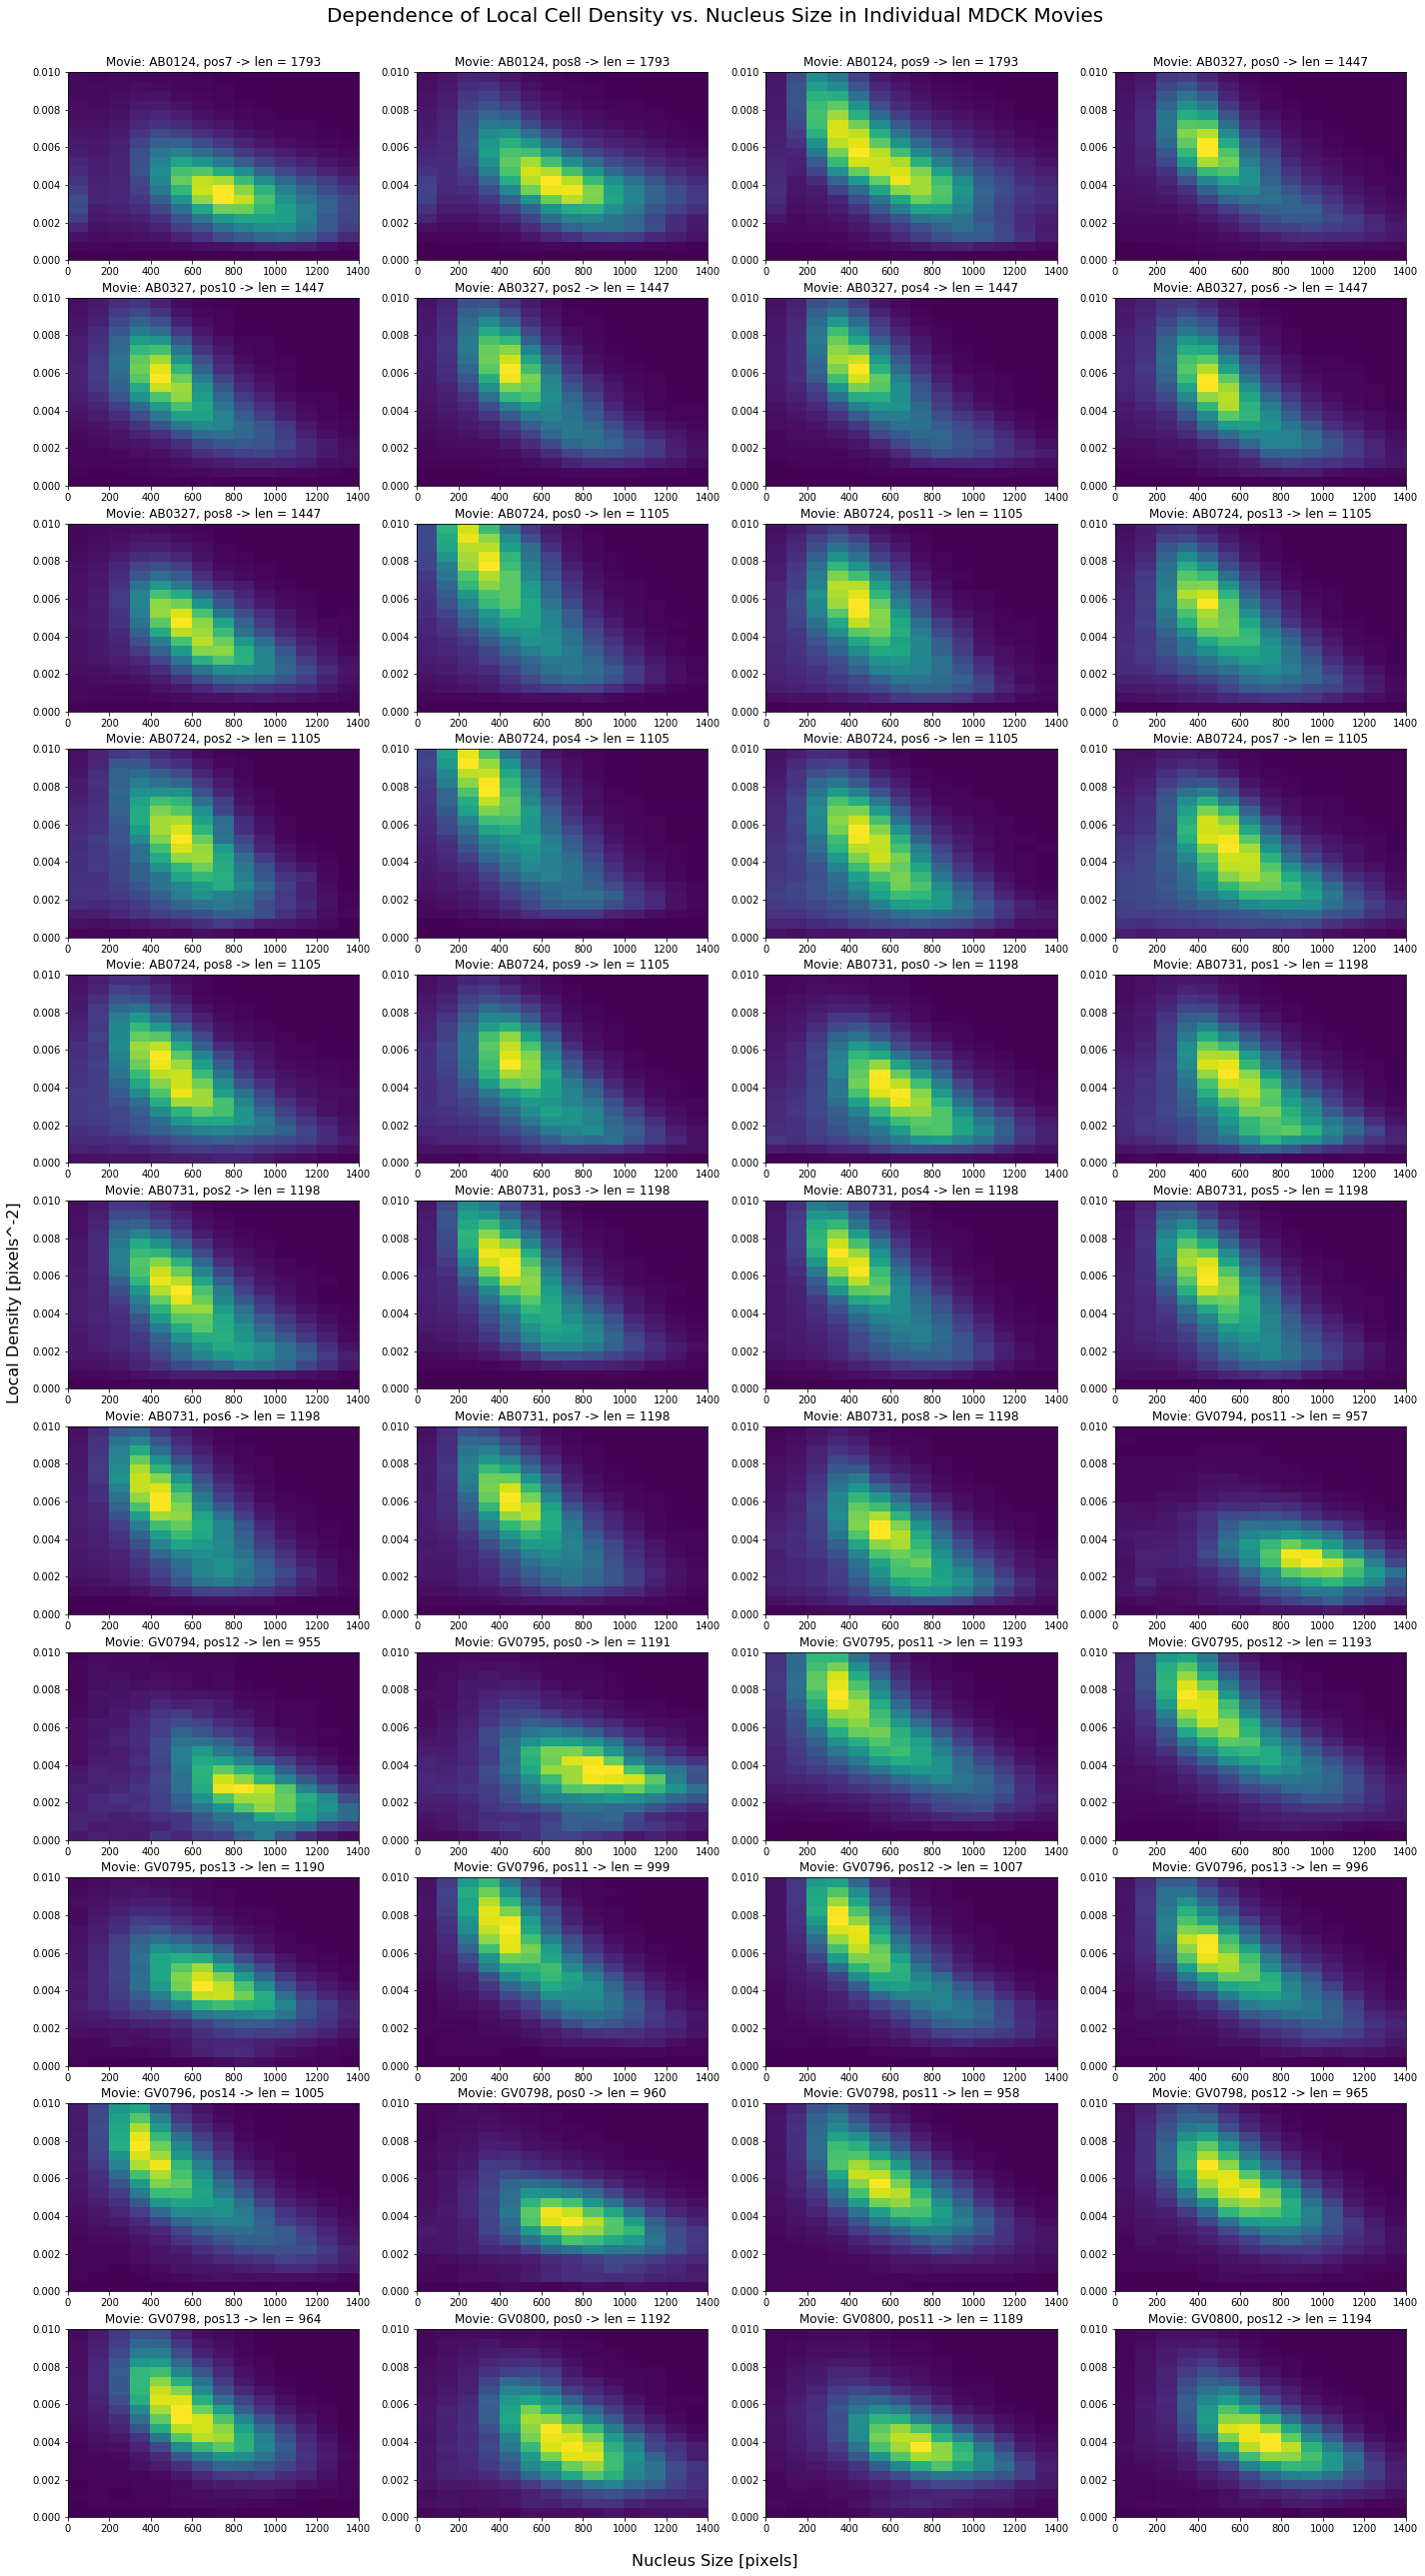

In [5]:
fig, axs = plt.subplots(figsize=(24, 45), nrows=11, ncols=4)
fig.suptitle(t="Dependence of Local Cell Density vs. Nucleus Size in Individual MDCK Movies", x=0.5, y=0.9, fontsize=20)
fig.text(x=0.5, y=0.11, s="Nucleus Size [pixels]", ha='center', fontsize=16)
fig.text(x=0.09, y=0.5, s="Local Density [pixels^-2]", va='center', rotation='vertical', fontsize=16)

for enum, movie in enumerate(movies):
    pos, date = movie.split("/")[-2], movie.split("/")[-3]
    hdf5_file = movie + "/HDF/segmented.hdf5"
    density, nucleus, length = Extract_Datasets(hdf5_file=hdf5_file)

    # Plot the individual 2D histograms for each file:
    axs[enum // 4, enum % 4].hist2d(x=nucleus, y=density, bins=[14, 20], range=[[0, 1400], [0, 0.01]])
    axs[enum // 4, enum % 4].set_title("Movie: {}, {} -> len = {}".format(date, pos, length))
            
plt.show()
plt.close()

### Now create a matrix of your counts and plot 2D histogram to summarize all of your data:

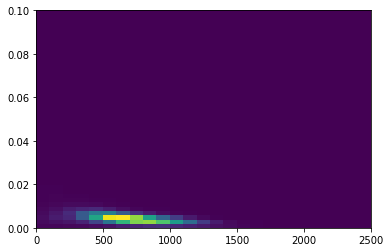

In [6]:
matrix = [[0 for _ in range(50)] for _ in range(25)]

for enum, movie in enumerate(movies):
    pos, date = movie.split("/")[-2], movie.split("/")[-3]
    hdf5_file = movie + "/HDF/segmented.hdf5"
    density, nucleus, length = Extract_Datasets(hdf5_file=hdf5_file)

    a, b, c, d = plt.hist2d(x=nucleus, y=density, bins=[25, 50], range=[[0, 2500], [0, 0.1]])
    for enum_row, row in enumerate(a):
        for enum_col, col in enumerate(row):
            matrix[enum_row][enum_col] += col
    

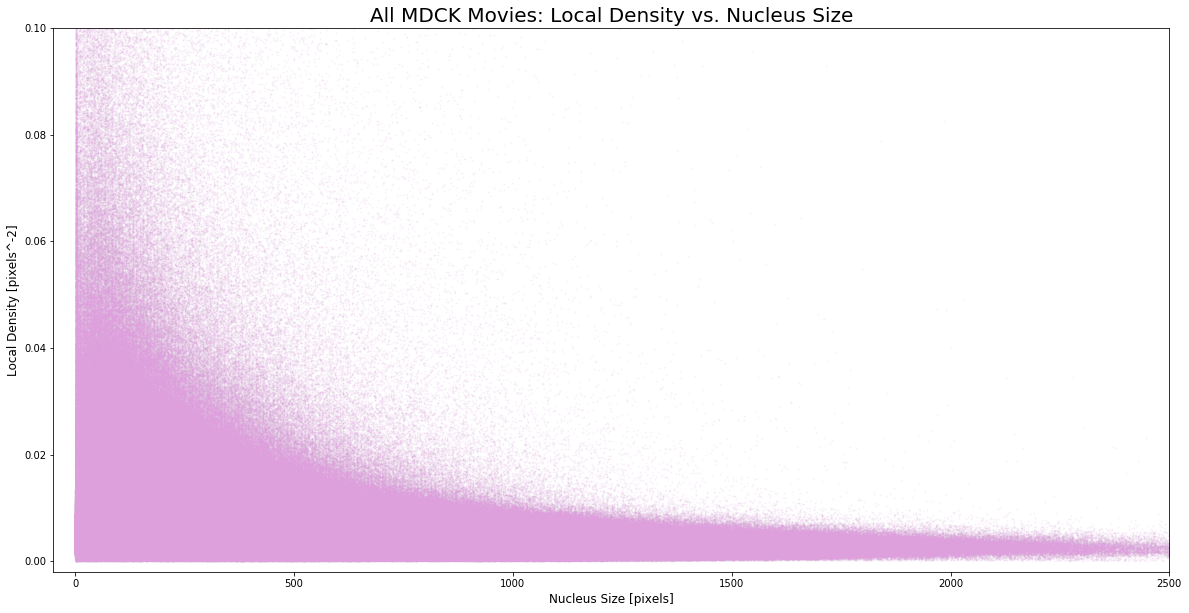

In [7]:
_ = plt.figure(figsize=(20, 10))

for enum, movie in enumerate(movies):
    pos, date = movie.split("/")[-2], movie.split("/")[-3]
    hdf5_file = movie + "/HDF/segmented.hdf5"
    density, nucleus, lenght = Extract_Datasets(hdf5_file=hdf5_file)

    plt.scatter(x=nucleus, y=density, s=1, color="plum", alpha=0.1)

plt.title("All MDCK Movies: Local Density vs. Nucleus Size", fontsize=20)
plt.xlim(-50, 2500)
plt.ylim(-0.002, 0.1)
plt.xlabel("Nucleus Size [pixels]", fontsize=12)
plt.ylabel("Local Density [pixels^-2]", fontsize=12)
plt.show()
plt.close()


### 3D BarPlot:

/Users/kristinaulicna/opt/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1773: RuntimeWarning: divide by zero encountered in true_divide
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))


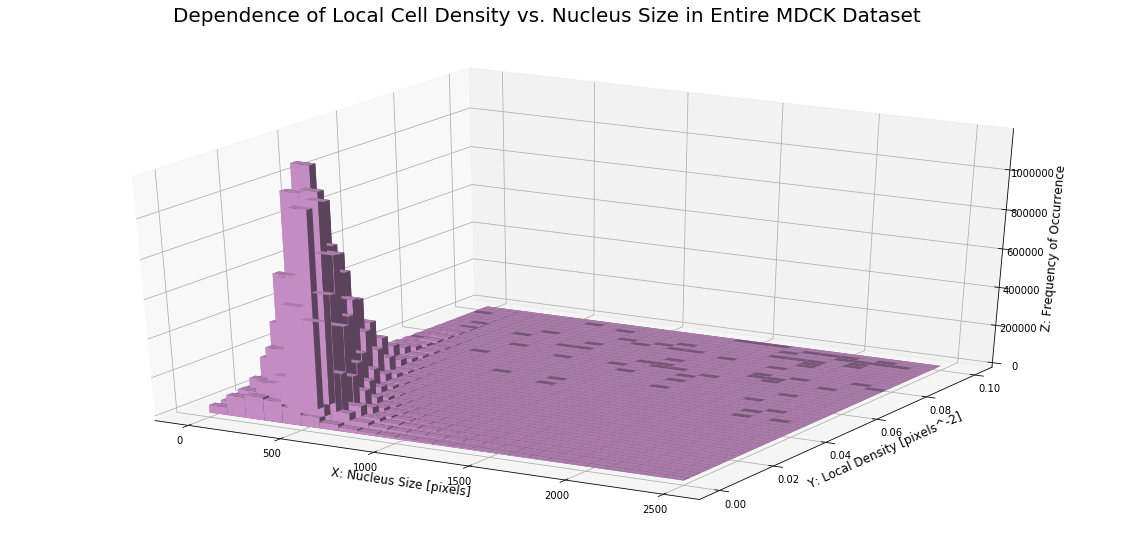

Total observations per scatter plot / 3D bar plot = 21605671.0; highest peak % = 5.457456054014708


In [9]:
# Prepare the figure, subplots, meshgrid & basic features:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=(20, 20))
fig.suptitle(t="Dependence of Local Cell Density vs. Nucleus Size in Entire MDCK Dataset", x=0.5, y=0.9, fontsize=20)
ax = fig.add_subplot(211, projection='3d')

width = 100
depth = 0.002
_x = np.arange(start=0, stop=2500, step=width)
_y = np.arange(start=0, stop=0.1, step=depth)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
top = np.array(matrix).ravel()
bottom = np.zeros_like(top)

# Plot the thing:
ax.bar3d(x, y, bottom, width, depth, top, color="plum", shade=True)
ax.set_xlabel('X: Nucleus Size [pixels]', labelpad=5, fontsize=12)
ax.set_ylabel('Y: Local Density [pixels^-2]', labelpad=5, fontsize=12)
ax.set_zlabel('Z: Frequency of Occurrence', labelpad=5, fontsize=12)

plt.show()
plt.close()

# Some probability statistics:
matrix_counter = 0
for enum_row, row in enumerate(matrix):
    for enum_col, col in enumerate(row):
        matrix_counter += col

max_percentage = []
for enum_row, row in enumerate(matrix):
    percentage = [item * 100 / matrix_counter for item in row]
    max_percentage.append(np.max(percentage))

print ("Total observations per scatter plot / 3D bar plot = {}; highest peak % = {}".format(matrix_counter, np.max(max_percentage)))
